#### Data Processing with Python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


###### IN CASE OF PROBLEMS IMPORTING PACKAGES


In [ ]:
# SOLUTION A: select this cell and type Shift-Enter to execute the code below.

%conda install openpyxl pandas seaborn

# Now restart the kernel (Menu -> Kernel -> Restart Kernel)

In [ ]:
# SOLUTION B: select this cell and type Shift-Enter to execute the code below.

%pip install openpyxl pandas seaborn

# Now restart the kernel (Menu -> Kernel -> Restart Kernel)

<hr>

Run the following cell to rebuild the three `DataFrames`:

In [2]:

# countries
countries = pd.read_excel("data_geographies_v1.xlsx", sheet_name = "list-of-countries-etc")

# co2
data = pd.read_csv("yearly_co2_emissions_1000_tonnes.csv")
co2 = data.melt(id_vars=['country'], var_name='year', value_name='kt')
co2.dropna(inplace=True)
co2["year"] = co2["year"].astype(int)

# stats97
data = pd.read_csv('stats_1997.csv', header=None)
df = data[0].str.split('-', expand=True)
df.columns = ['geo','statistic']
df['value'] = data[1]
stats97 = df.pivot(index='geo',columns='statistic',values='value')


# 5. Manipulating Data

In this notebook, we will look at some more of pandas's data-handling tools.

***
## 5.1 Joining tables

To compare emissions between countries in a fair way, it would make sense to convert them to a per-capita basis. 
Let's start with the figures for 1997 to see how this can be done.

First we will make a new dataframe containing only the 1997 emissions:

In [6]:
co2_1997 = co2.query('year==1997')
co2_1997

,country,year,kt
47232,Afghanistan,1997,1100.0
47233,Albania,1997,1540.0
47234,Algeria,1997,87300.0
47235,Andorra,1997,466.0
47236,Angola,1997,7380.0
...,...,...,...
47419,Venezuela,1997,134000.0
47420,Vietnam,1997,45100.0
47421,Yemen,1997,13400.0
47422,Zambia,1997,2390.0


However, the population data is not yet in the co2 dataframe, so we will need to look it up from another dataframe by matching the country name. 

This type of **relational data**, where information must be collected from multiple tables, requires careful handling to make sure that rows in different tables are correctly associated with each other. The country name acts as a **key** to unlock the correct data from the associated table.

The relevant population data is in the stats97 table: 

In [3]:
stats97

statistic,gdp,pop
geo,,
afg,NaN,18400000.0
ago,2.570000e+10,15100000.0
alb,5.470000e+09,3090000.0
and,2.400000e+09,64300.0
are,1.730000e+11,2700000.0
...,...,...
wsm,4.330000e+08,172000.0
yem,1.740000e+10,16400000.0
zaf,2.490000e+11,43700000.0


However, this is indexed by the `geo` code, rather than the `country` name that we find in `co2_1997`. Fortunately, the `countries` table contains both:

In [4]:
countries.head()

,geo,name,four_regions,eight_regions,six_regions,members_oecd_g77,Latitude,Longitude,UN member since,World bank region,"World bank, 4 income groups 2017"
0,afg,Afghanistan,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income
1,alb,Albania,europe,europe_east,europe_central_asia,others,41.00000,20.00000,1955-12-14,Europe & Central Asia,Upper middle income
2,dza,Algeria,africa,africa_north,middle_east_north_africa,g77,28.00000,3.00000,1962-10-08,Middle East & North Africa,Upper middle income
3,and,Andorra,europe,europe_west,europe_central_asia,others,42.50779,1.52109,1993-07-28,Europe & Central Asia,High income
4,ago,Angola,africa,africa_sub_saharan,sub_saharan_africa,g77,-12.50000,18.50000,1976-12-01,Sub-Saharan Africa,Lower middle income


Taking the `co2_1997` data, we apply a `join()` to relate its `country` variable to the `name` variable in `countries`.

To do this, we need to set these columns as the index in each table

In [ ]:
a = co2_1997.set_index('country')
b = countries.set_index('name')
c = a.join(b)
c.head()


For every row in the table `a`, `join()` tries to match its index with a row index in `b`. 
The resulting table imports the additional columns from the `countries` tibble, so now we can associate each `geo` code with the correct CO2 emissions.

`join()` is just one of several pandas methods for working with relational data.


#### Exercise {-}

Use another `join()` to connect `c` to `stats97`.

*Hint*: you can move the current index column back into the body of the DataFrame using the method [`reset_index()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html?highlight=reset_index#pandas.DataFrame.reset_index)

In [24]:
c =c.reset_index()
c.head()
d=c.set_index('geo')
data_97=d.join(stats97)
data_97.head()

,country,year,kt,four_regions,eight_regions,six_regions,members_oecd_g77,Latitude,Longitude,UN member since,World bank region,"World bank, 4 income groups 2017",gdp,pop
geo,,,,,,,,,,,,,,
afg,Afghanistan,1997,1100.0,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN,18400000.0
alb,Albania,1997,1540.0,europe,europe_east,europe_central_asia,others,41.00000,20.00000,1955-12-14,Europe & Central Asia,Upper middle income,5.470000e+09,3090000.0
dza,Algeria,1997,87300.0,africa,africa_north,middle_east_north_africa,g77,28.00000,3.00000,1962-10-08,Middle East & North Africa,Upper middle income,9.810000e+10,29900000.0
and,Andorra,1997,466.0,europe,europe_west,europe_central_asia,others,42.50779,1.52109,1993-07-28,Europe & Central Asia,High income,2.400000e+09,64300.0
ago,Angola,1997,7380.0,africa,africa_sub_saharan,sub_saharan_africa,g77,-12.50000,18.50000,1976-12-01,Sub-Saharan Africa,Lower middle income,2.570000e+10,15100000.0


#### Exercise {-}

Calculate the per-capita emissions for 1997 as a new column and plot these on a histogram.

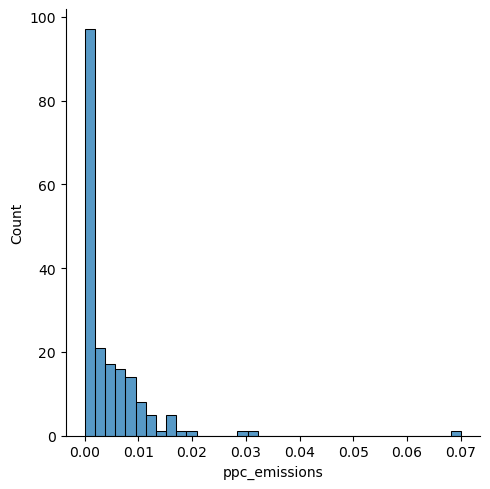

In [ ]:
data_97['ppc_emissions']= data_97['kt']/data_97['pop']
data_97.head()
sns.displot(data=data_97, x="ppc_emissions", bin=20, color='red')
plt.show()

#### Exercise {-}

The file `population_total.csv` contains (real or predicted) population data for each country for the years 1800-2100.

Write a workflow to construct a new DataFrame `co2_pp` containing the following columns:

* country
* year
* kt = total CO2 emissions (in kilotonnes)
* pop = total population
* t_pp = per-capita CO2 emissions (in tonnes)



In [124]:
population= pd.read_csv("population_total.csv")
population.head()
#melt: to seperate the 'year' label -> into year column, value under year as "population" column
# pop and year column
#melt data: use country as identifier, years as variable, the value under "years" as "pop"(population)
co2_pp= pd.melt(population, id_vars="country", var_name="years",value_name="pop")

co2_pp.head()

#add kt column
co2_pp['kt']= co2['kt']
co2_pp.dropna(inplace=True)
co2_pp['years']=co2_pp['years'].astype(int)


#add t_pp (per capita CO2 emission)
co2_pp['t_pp']= co2_pp['kt']/co2_pp['pop']
co2_pp.head()

,country,years,pop,kt,t_pp
182,Uganda,1800,2100000,9360.0,0.004457
374,Turkey,1801,9790000,9360.0,0.000956
566,Tonga,1802,18700,9360.0,0.500535
758,Thailand,1803,4670000,9370.0,0.002006
950,Syria,1804,1340000,9370.0,0.006993


***

## 5.2 Summarising data across groups

Cases often belong to distinct groups that we want to compare with each other in some way.


#### Exercise {-}

Using the output of the previous exercise and the `countries` dataframe, add a column for the `eight_regions` grouping.

In [123]:
#extracting the name and region column
eightreg =countries[['name','eight_regions']]
#rename the country column as 'country' to match the col name in co2_pp
eightreg.columns =['country','eight_regions']
#important step: set country as index to pair countries with eight_regions
eightreg=eightreg.set_index('country')
co2_pp= co2_pp.set_index('country').join(eightreg)

co2_pp.head()

,years,pop,kt,t_pp,eight_regions
country,,,,,
Uganda,1800,2100000,9360.0,0.004457,africa_sub_saharan
Turkey,1801,9790000,9360.0,0.000956,europe_east
Tonga,1802,18700,9360.0,0.500535,east_asia_pacific
Thailand,1803,4670000,9370.0,0.002006,east_asia_pacific
Syria,1804,1340000,9370.0,0.006993,asia_west


## Box plots

Let's look at the data for 2014 only. Here's a more complex visualisation of the data:

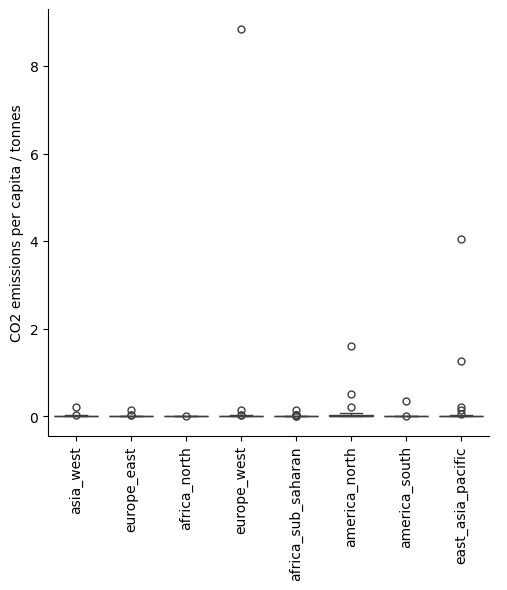

In [69]:
d = co2_pp.query('years==2014')
g = sns.catplot(x="eight_regions",y="t_pp",data=d,kind="box")
g.set_axis_labels("", "CO2 emissions per capita / tonnes")
g.set_xticklabels(rotation=90)
plt.show()

## groupby()

Pandas allows you to define groups of rows and construct summary statistics for each group:

In [ ]:
grouped = d.groupby("eight_regions")

In [118]:
grouped['t_pp'].median()

years  eight_regions     
1950   africa_north          0.047831
       africa_sub_saharan    0.002719
       america_north         0.000523
       america_south         0.009238
       asia_west             0.005832
                               ...   
2024   america_south         0.000080
       asia_west             0.001166
       east_asia_pacific     0.000589
       europe_east           0.002632
       europe_west           0.001697
Name: t_pp, Length: 594, dtype: float64

##### *Exercise*

Plot the total global CO2 emissions for each year.


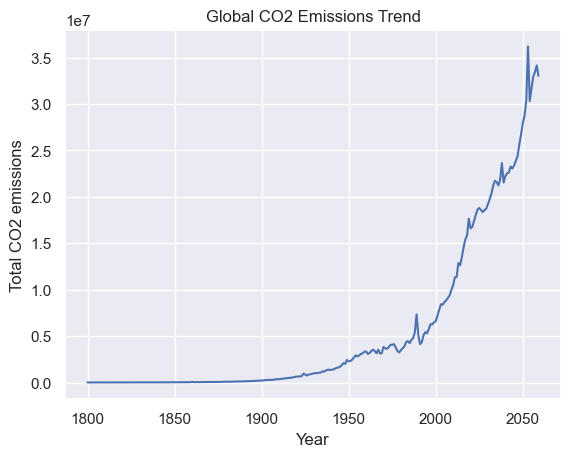

In [ ]:
kt_year = co2_pp[['country','years','kt']]
kt_yeartotal= kt_year.groupby("years").sum()
#set palette of seaborn plot
#sns.color_palette("Set2")
sns.set_theme()

plot1=sns.lineplot(kt_yeartotal,x='years',y='kt')
plot1.set(xlabel="Year",ylabel="Total CO2 emissions",title="Global CO2 Emissions Trend")
plt.show()

##### *Exercise*

Plot the yearly median per-capita CO2 emissions for the eight regions, from 1950 onwards.


In [ ]:
co2_pp = co2_pp.drop(['level_0','index'],axis=1)

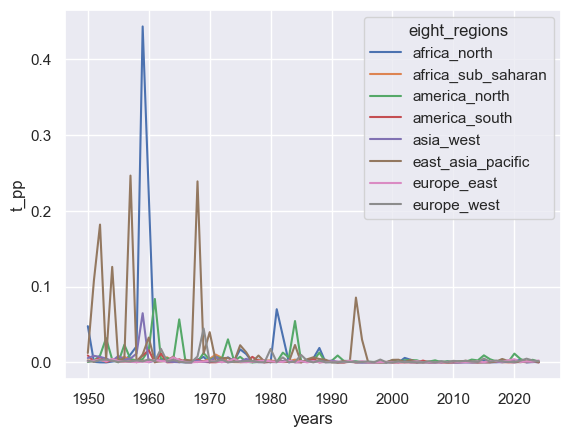

In [117]:
kt1950= co2_pp.query('1950 <= years <= 2024')
grouped= kt1950[['years','eight_regions','t_pp']].groupby(['years','eight_regions'])

#get median of all those countries in each 8 regions
ktmedian1950= grouped.median()
ktmedian1950= ktmedian1950.reset_index()
ktmedian1950.head()
#t_pp is the yearly per capita emission
plot2=sns.lineplot(ktmedian1950,x='years', y='t_pp', hue='eight_regions')
plt.show()


***